In [1]:

%matplotlib inline

import xml.etree.ElementTree as ET
import re
import os
import numpy as np
import time
import cv2 as cv
import glob, os
import json
import csv
import matplotlib.image as mpimg
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import LinearSegmentedColormap

global print_flag
global plot_flag

my_gradient = 'nipy_spectral'

'''
For camera N: load parameters from cam<N>.xml 
'''
def load_params(filename):

    tree = ET.parse(filename)
    root = tree.getroot()

    w = int(root[0][2].text) # number of columns in camera sensor
    h = int(root[0][3].text) # number of rows in camera sensor

    # Regular expression to get values out of *.xml
    rescinot = re.compile('[-+]?[\d]+\.?[\d]*[Ee](?:[-+]?[\d]+)?|[\d]')

    # Get Camera Matrix 
    cam_m = np.array(re.findall(rescinot, root[0][0][3].text))

    # Get Distortion Coefficients
    d_coeff = np.array(re.findall(rescinot, root[0][1][3].text))

    # Refactoring matrices and coefficients
    cam_m = cam_m.astype(np.float64).reshape((3,3))
    d_coeff = d_coeff.astype(np.float64)
    
    return w, h, cam_m, d_coeff


'''
Sometimes there are more than 3 occurrences per pixel.
These occurrences are marginal and, if taken into account, make the histograms look 'horrible'
For this reason, this functions just replaces occurences >3 by 3
Also, on the 'activity side' one pixel is artificially set to 0 to 'standardize' the colormap 'render'
'''
def rework_occ_act(occurrences, activity):
    
    occ_stats = np.reshape(occurrences, (occurrences.shape[0]*occurrences.shape[1],1))
    act_stats = np.reshape(activity, (activity.shape[0]*activity.shape[1],1))
    
    occurrences[occurrences > 2] = 3
    activity[0][0] = 0 
    
    return occurrences, occ_stats, activity, act_stats
    
    
'''
This functions allows to analyze occurrences and activity by creating meaningful histogram bins
'''
def get_hist_data(occurrences, activity):
    
    results = np.zeros((3, 4), dtype=float)
    
    occurrences, occ_stats, activity, act_stats = rework_occ_act(occurrences, activity)
    
    occ_bin_array = range(min(11,np.amax(occurrences+2)))
    occ_n, occ_bins = np.histogram(occ_stats, bins=occ_bin_array)
    
    if print_flag:
        print("   Total # of occurrences (from undistorted): %d" %(np.sum(occ_n)))
    for i in range(len(occ_bins)-1):
        if print_flag:
            print("      %d : %d (%2.2f%%)" %(occ_bins[i], occ_n[i], 100*occ_n[i]/np.sum(occ_n)))
        
        if occ_bins[i] == 0:
            results[1,0] = 100*occ_n[i]/np.sum(occ_n)
        elif occ_bins[i] == 1:
            results[1,1] = 100*occ_n[i]/np.sum(occ_n)
        elif occ_bins[i] == 2:
            results[1,2] = 100*occ_n[i]/np.sum(occ_n)
        else:
            results[1,3] = 100*occ_n[i]/np.sum(occ_n)
            
    
    act_bin_array = range(min(11,np.amax(activity+2)))
    act_n, act_bins = np.histogram(act_stats, bins=act_bin_array)        
    
    if print_flag: 
        print("   Total # of active pixels (in undistorted): %d" %(np.sum(act_n)))
    for i in range(len(act_bins)-1):
        if print_flag:
            print("      %d : %d (%2.2f%%)" %(act_bins[i], act_n[i], 100*act_n[i]/np.sum(act_n)))
        
        if act_bins[i] == 0:
            results[2,0] = 100*act_n[i]/np.sum(act_n)
        elif act_bins[i] == 1:
            results[2,1] = 100*act_n[i]/np.sum(act_n)
        elif act_bins[i] == 2:
            results[2,2] = 100*act_n[i]/np.sum(act_n)
        else:
            results[2,3] = 100*act_n[i]/np.sum(act_n)
    
    for i in range(4):
        results[0,i] = (results[1,i] + results[2,i])/2
    
    return results

'''
This function plots the following images in a row:
- distorted
- undistorted
- occurrences
- activity
- histogram of occurrences
- histogram of activity
'''
def plot_all(idx_z, axs, distorted, undistorted, occurrences, activity):
    
    global print_flag
    
    occurrences, occ_stats, activity, act_stats = rework_occ_act(occurrences, activity)
    occ_bin_array = range(min(11,np.amax(occurrences+2)))
    act_bin_array = range(min(11,np.amax(activity+2)))
    
    axs[idx_z, 0].axis('off')
    axs[idx_z, 1].axis('off')
    axs[idx_z, 2].axis('off')
    axs[idx_z, 3].axis('off')
    axs[idx_z, 4].axis('on')
    axs[idx_z, 5].axis('on')
    
    axs[idx_z, 0].imshow(distorted)
    axs[idx_z, 1].imshow(undistorted)  
    axs[idx_z, 2].imshow(occurrences, cmap=my_gradient) 
    axs[idx_z, 3].imshow(activity) 
    occ_n, occ_bins, occ_patches = axs[idx_z, 4].hist(occ_stats, bins=occ_bin_array, facecolor='green', alpha=1, align='left',edgecolor='black') 
    act_n, act_bins, act_patches = axs[idx_z, 5].hist(act_stats, bins=act_bin_array, facecolor='green', alpha=1, align='left',edgecolor='black')
    
    axs[idx_z, 3].axes.set_xticks(occ_bin_array, minor=False)
    axs[idx_z, 5].axes.set_xticks(act_bin_array, minor=False)
    
    axs[idx_z, 0].title.set_text('Distorted (z=%1.2f) ' %(z))
    axs[idx_z, 1].title.set_text('Undistorted (z=%1.2f) ' %(z))
    axs[idx_z, 2].title.set_text('Occurrences (z=%1.2f) ' %(z))
    axs[idx_z, 3].title.set_text('Activity (z=%1.2f) ' %(z))
    axs[idx_z, 4].title.set_text('Occurrences (z=%1.2f) ' %(z))
    axs[idx_z, 5].title.set_text('Activity (z=%1.2f) ' %(z))
    
'''
Using camera matrix and distortion coefficients, open CV estimates how to map from distorted to undistorted space
The output is a pair (one for x, one for y) of w*h matrices (or maps)
'''    
def get_distortion_maps(w, h, cam_m, d_coeff, z):
    
    global print_flag
        
    # Undistorting stuff ...
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(cam_m, d_coeff, (h,w), z, (h,w))
    mapx, mapy = cv.initUndistortRectifyMap(cam_m, d_coeff, None, newcameramtx, (w,h), 5)
    
    return mapx, mapy

'''
This functions initializes a look-up-table that will store mappings from distorted to undistorted pixels
'''
def create_empty_lut(w, h):
    
    lut = {}    
    for i in range(w): #640
        for j in range(h): #480                               
                idx = h*i+j
                lut[idx] = []
    return lut

'''
This function sweeps 'undistorted' and uses mapx/mapy to get a value from a pixel in 'distorted' 
While the undistortion happens, a look-up table is created so, next time, we can sweep 'distorted' to get 'undistorted'
'''
def undistort_pt_by_pt(distorted, mapx, mapy):
    
    x = distorted.shape[1]
    y = distorted.shape[0]
    
    occurrences = np.zeros((y,x), dtype=int)
    undistorted = np.zeros(distorted.shape, dtype=int)
    
    lut = create_empty_lut(x, y)   
    for i in range(x): #640
        for j in range(y): #480  
            old_x = int(mapx[j, i]) 
            old_y = int(mapy[j, i]) 
            if ((old_x>=0) and (old_x<x)) and ((old_y>=0) and (old_y<y)):
                undistorted[j, i, :] = distorted[old_y, old_x, :]
                occurrences[old_y, old_x] += 1                             
                idx = y*old_x+old_y
                lut[idx].append([i,j])
    
    return undistorted, occurrences, lut

'''
This function allows to store look-up tables as *.json files
'''
def save_lut_as_json(lut, name):    
    lut_file = open('undistortion/' + name + '.json', "w")
    json.dump(lut, lut_file)
    lut_file.close()

    
    
def save_lut_as_csv(lut, name):
    filepath = 'undistortion/' + name + '.csv'
    count_0 = 0
    count_1 = 0
    count_2 = 0
    count_x = 0
    count_l = 0
    with open (filepath, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file,delimiter=',')
        for i in range(len(lut)):
            l = [i,-1,-1,-1,-1]
            go_write = True
            if len(lut[i]) == 0:
                count_0 +=1
                go_write = False
            elif len(lut[i]) == 1:
                count_1 +=1
            elif len(lut[i]) == 2:
                count_2 +=1
            elif len(lut[i]) >= 3:
                count_x +=1
                
            for pixix in range(min(2,len(lut[i]))):
                l[1+pixix*2+0]=(lut[i][pixix][0])
                l[1+pixix*2+1]=(lut[i][pixix][1])
                
            if go_write:
                csv_writer.writerow(l)
                count_l += 1
            
    print(f"c0 = {count_0}")
    print(f"c1 = {count_1}")
    print(f"c2 = {count_2}")
    print(f"cx = {count_x}")
    print(f"cl = {count_l}")

    
'''
This function sweeps 'distorted' and maps its pixels to a set of pixels in 'undistorted' according to 'lut'
'''
def undistort_with_lut(distorted, lut):
    
    x = distorted.shape[1]
    y = distorted.shape[0]
    
    activity = np.zeros((y,x), dtype=int)
    undistorted = np.zeros(distorted.shape, dtype=int)
    for i in range(x): #640
        for j in range(y): #480  
            idx = y*i+j
            for k in range(len(lut[idx])):
                undistorted[lut[idx][k][1], lut[idx][k][0], :] = distorted[j, i, :]
                activity[lut[idx][k][1], lut[idx][k][0]] += 1
            
            
    return undistorted, activity

       
'''
This function shows plots, one per camera, were the % of unused/active pixels is a function of 'z'
'''
def plot_results(cam_array, z_array, results):
    
    blue = '#326BEF'
    orange = '#F9920B'
    green = '#21CA7B'
    red = '#EC1136'
    legends_left = ['avg.', 'occ.', 'act.']
    l_styles = ['-', '--', ':']
    legends_right = ['N=0', 'N=1', 'N=2', 'N>2']
    l_colors = [blue, orange, green, red]
    
    best_z = np.zeros(len(cam_array))
    
    for camera_id in cam_array:    
        best_z[camera_id-1] = z_array[np.argmin(results[camera_id-1,:,0,0])]
        plt.figure(figsize=(12, 6))
        
        for i in range(3):
            for j in range(4):
                c_lab = legends_left[i] + " " + legends_right[j]
                plt.plot(z_array, results[camera_id-1,:,i,j], linestyle=l_styles[i], color=l_colors[j], label=c_lab)
        plt.axvline(best_z[camera_id-1], color='k', label='z=%1.2f' %(best_z[camera_id-1]), linestyle='--')
        plt.legend(bbox_to_anchor=(1.2, 0.65))
        plt.xlim([0, 1])
        plt.xlabel('z', fontsize=14)
        plt.ylim([0, 100])
        plt.ylabel('% of unused/inactive pixels', fontsize=14)
        plt.grid()
        plt.suptitle("CAMERA #%d" %(camera_id), fontsize=18)
        




For Camera #1
c0 = 54553
c1 = 215616
c2 = 29203
cx = 7828
cl = 252647



For Camera #2
c0 = 26488
c1 = 256315
c2 = 22990
cx = 1407
cl = 280712



For Camera #3
c0 = 33807
c1 = 243567
c2 = 27190
cx = 2636
cl = 273393



For Camera #4
c0 = 22076
c1 = 266132
c2 = 18049
cx = 943
cl = 285124
The whole thing took: 223 seconds.


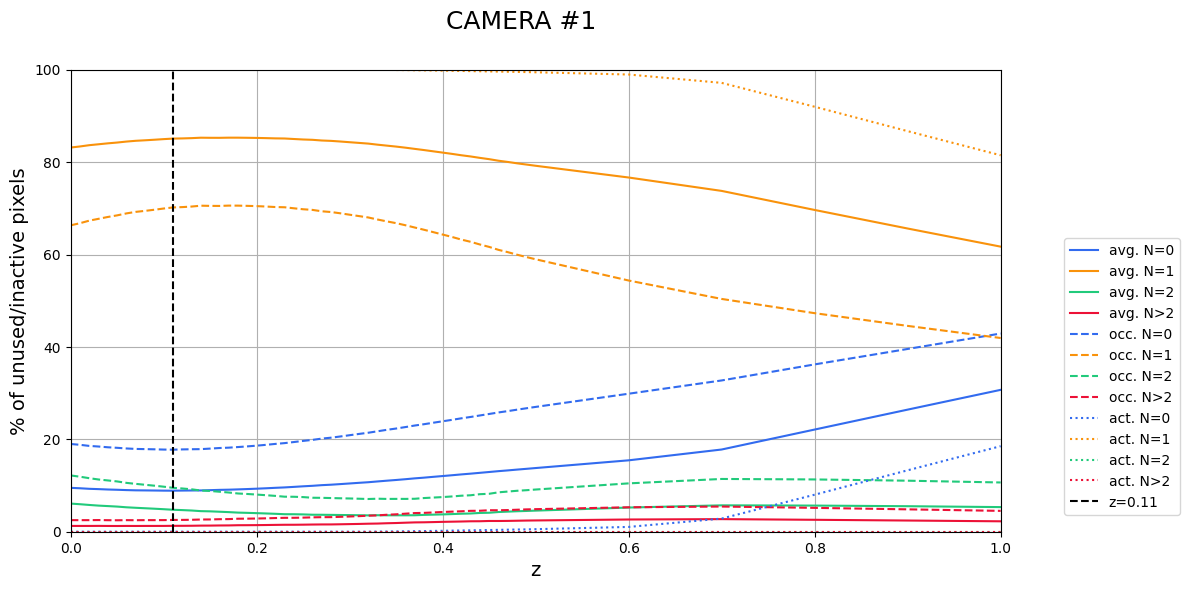

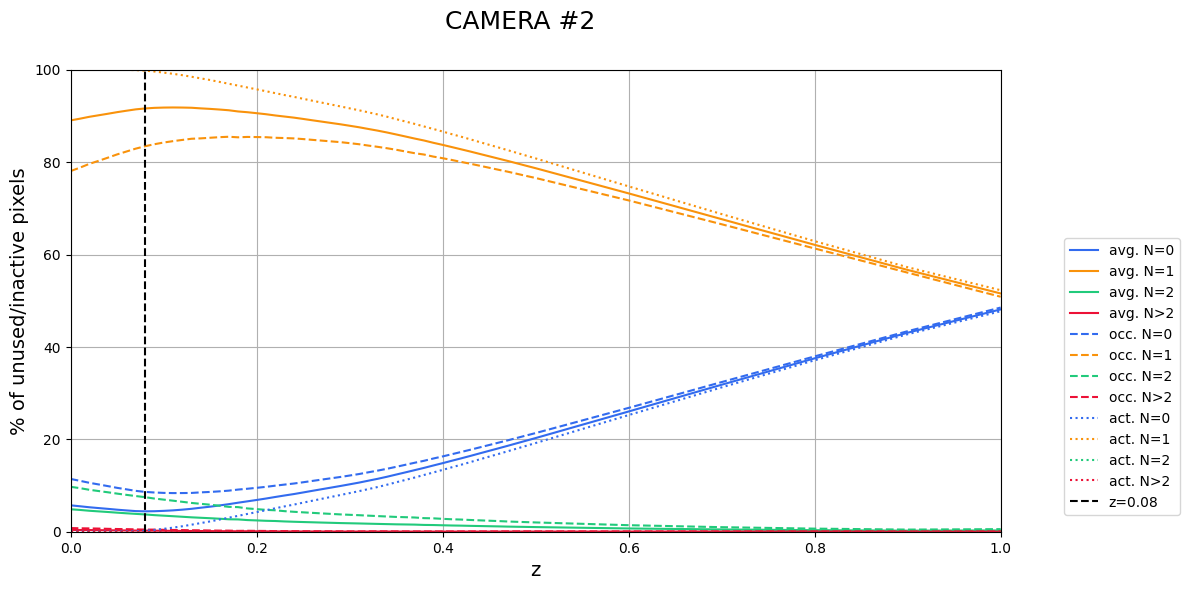

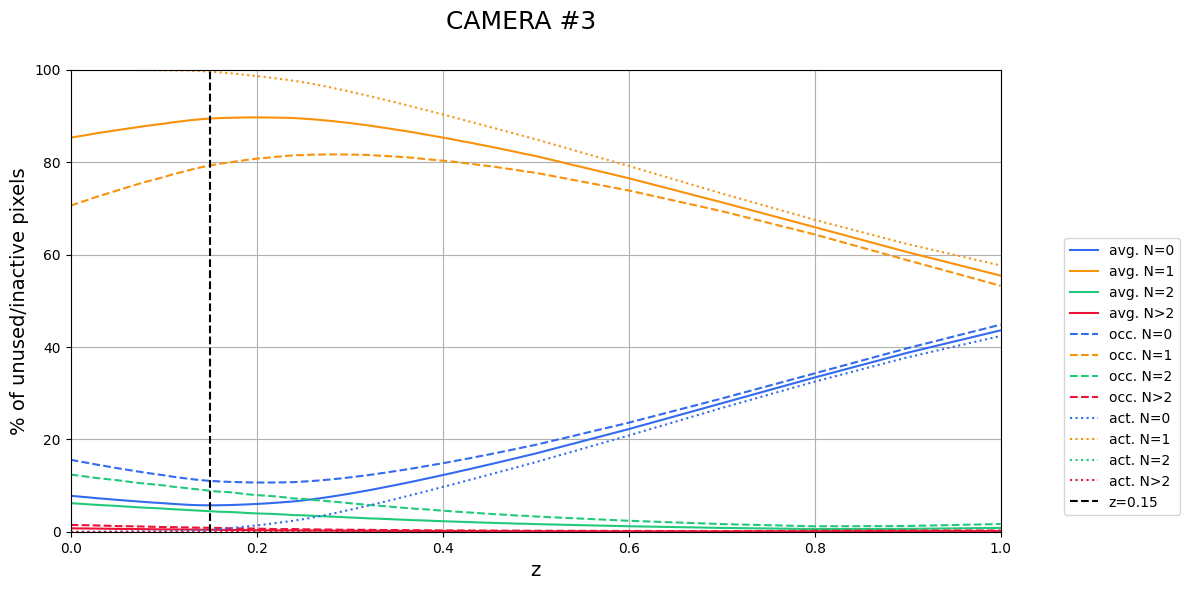

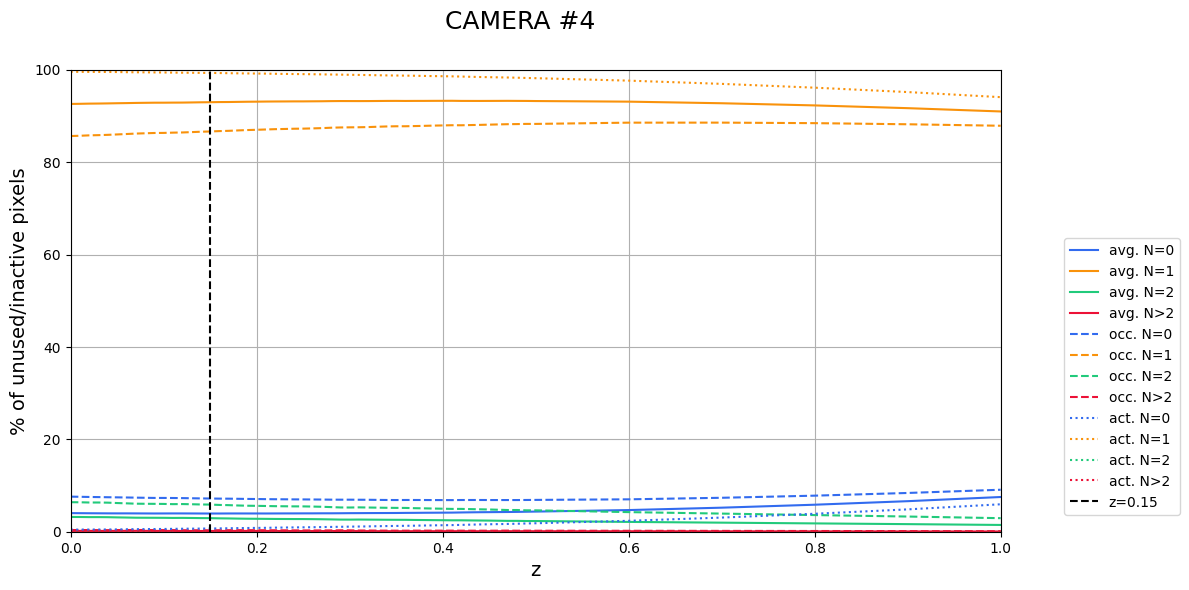

In [2]:

if __name__ == "__main__":
    
    global print_flag
    global plot_flag

    print_flag = False
    plot_flag = False

    super_start = time.time()

    # Cameras for which *.xml are available
    cam_list = []
    # Array of camera ids to considercam_list = []
    for path in glob.glob("calibration/parameters/*.xml"):
        file = path.replace('calibration/parameters/cam', '')
        cam_id = file.replace('.xml', '')
        cam_list.append(int(cam_id))
    cam_array = np.array(sorted(cam_list))

    # Array of 'z' values to test
    step = 0.01
    z_roi = [0.0,0.5]
    z_array = np.unique(np.sort(np.concatenate([np.arange(0,1.1,0.1), np.arange(z_roi[0],z_roi[1],step)])))

    results = np.zeros((len(cam_array), len(z_array), 3, 4), dtype=float)

    for camera_id in cam_array:  

        print("\n\n\nFor Camera #%d" %(camera_id))
        img_name = "images/distorted_" + str(camera_id) + ".png"
        distorted = cv.imread(img_name)  

        # Reading parameters from *.xml
        w, h, cam_m, d_coeff = load_params("calibration/parameters/cam" + str(camera_id) + ".xml")
        if print_flag:
            print("Loading %s" %("calibration/parameters/cam" + str(camera_id) + ".xml"))

        # Prepare figures (if needed/wanted)
        if plot_flag:
            fig, axs = plt.subplots(len(z_array),6, figsize=(20,4*len(z_array)))
            fig.tight_layout(pad=5.0)

        # Evaluate undistortion for each 'z' 
        idx_z = 0
        lowest_val = 100
        for z in z_array: 

            if print_flag:
                print("\t ... with z=%1.2f" %(z))                  

            # Get distortion maps
            mapx, mapy = get_distortion_maps(w, h, cam_m, d_coeff, z)

            # Get undistorted image (using distortion maps)
            start = time.time()
            undistorted_map, occurrences, lut = undistort_pt_by_pt(distorted, mapx, mapy)
            stop = time.time()
            elapsed = stop - start

            # Get undistorted image (using lut)
            start = time.time()
            undistorted_lut, activity = undistort_with_lut(distorted, lut)
            stop = time.time()
            elapsed = stop - start

            results[camera_id-1, idx_z, :, :] = get_hist_data(occurrences, activity)

            # Keep current best 'z' in memory
            if lowest_val > results[camera_id-1, idx_z, 0, 0]:
                lowest_val = results[camera_id-1, idx_z, 0, 0]
                best_lut = lut
                best_z = z


            if plot_flag:
                plot_all(idx_z, axs, distorted, undistorted_lut, occurrences, activity)


            idx_z += 1

        try:
            save_lut_as_json(best_lut, 'cam_' + str(camera_id))
            save_lut_as_csv(best_lut, 'cam_' + str(camera_id))
        except:
            pass

        if plot_flag:
            plt.pause(1)
            plt.clf() 

    # Plot, for each camera, the % of unused/inactive bits as a function of 'z'
    plot_results(cam_array, z_array, results)

    super_stop = time.time()
    super_elapsed = super_stop - super_start
    print("The whole thing took: " + str(int(super_elapsed)) + " seconds.")